# Afriat

In [1]:
ood_seed = 11

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('24', 'Periportal', 'Infected')


Removed datapoint: 692

train         14596
validation     3765
ood             692
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 44%|████▍     | 8405/19053 [00:00<00:00, 84043.67it/s]

 96%|█████████▌| 18322/19053 [00:00<00:00, 92932.16it/s]

100%|██████████| 19053/19053 [00:00<00:00, 90161.77it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 859392.77it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 337.68it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:10<1:12:29, 10.90s/it]

Epoch 1/400:   0%|          | 1/400 [00:10<1:12:29, 10.90s/it, v_num=1, recon=4e+3, r2_mean=0.199, adv_loss=3.29, acc_pert=0.259, acc_zone=0.731, acc_status_control=0.5]

Epoch 2/400:   0%|          | 1/400 [00:10<1:12:29, 10.90s/it, v_num=1, recon=4e+3, r2_mean=0.199, adv_loss=3.29, acc_pert=0.259, acc_zone=0.731, acc_status_control=0.5]

Epoch 2/400:   0%|          | 2/400 [00:21<1:10:51, 10.68s/it, v_num=1, recon=4e+3, r2_mean=0.199, adv_loss=3.29, acc_pert=0.259, acc_zone=0.731, acc_status_control=0.5]

Epoch 2/400:   0%|          | 2/400 [00:21<1:10:51, 10.68s/it, v_num=1, recon=3.27e+3, r2_mean=0.61, adv_loss=2.79, acc_pert=0.377, acc_zone=0.832, acc_status_control=0.664]

Epoch 3/400:   0%|          | 2/400 [00:21<1:10:51, 10.68s/it, v_num=1, recon=3.27e+3, r2_mean=0.61, adv_loss=2.79, acc_pert=0.377, acc_zone=0.832, acc_status_control=0.664]

Epoch 3/400:   1%|          | 3/400 [00:32<1:11:48, 10.85s/it, v_num=1, recon=3.27e+3, r2_mean=0.61, adv_loss=2.79, acc_pert=0.377, acc_zone=0.832, acc_status_control=0.664]

Epoch 3/400:   1%|          | 3/400 [00:32<1:11:48, 10.85s/it, v_num=1, recon=3.23e+3, r2_mean=0.712, adv_loss=2.69, acc_pert=0.402, acc_zone=0.838, acc_status_control=0.662]

Epoch 4/400:   1%|          | 3/400 [00:32<1:11:48, 10.85s/it, v_num=1, recon=3.23e+3, r2_mean=0.712, adv_loss=2.69, acc_pert=0.402, acc_zone=0.838, acc_status_control=0.662]

Epoch 4/400:   1%|          | 4/400 [00:46<1:20:06, 12.14s/it, v_num=1, recon=3.23e+3, r2_mean=0.712, adv_loss=2.69, acc_pert=0.402, acc_zone=0.838, acc_status_control=0.662]

Epoch 4/400:   1%|          | 4/400 [00:46<1:20:06, 12.14s/it, v_num=1, recon=3.21e+3, r2_mean=0.747, adv_loss=2.67, acc_pert=0.407, acc_zone=0.829, acc_status_control=0.652]

Epoch 5/400:   1%|          | 4/400 [00:46<1:20:06, 12.14s/it, v_num=1, recon=3.21e+3, r2_mean=0.747, adv_loss=2.67, acc_pert=0.407, acc_zone=0.829, acc_status_control=0.652]

Epoch 5/400:   1%|▏         | 5/400 [00:57<1:15:58, 11.54s/it, v_num=1, recon=3.21e+3, r2_mean=0.747, adv_loss=2.67, acc_pert=0.407, acc_zone=0.829, acc_status_control=0.652]

Epoch 5/400:   1%|▏         | 5/400 [00:57<1:15:58, 11.54s/it, v_num=1, recon=3.2e+3, r2_mean=0.768, adv_loss=2.57, acc_pert=0.462, acc_zone=0.834, acc_status_control=0.637] 

Epoch 6/400:   1%|▏         | 5/400 [00:57<1:15:58, 11.54s/it, v_num=1, recon=3.2e+3, r2_mean=0.768, adv_loss=2.57, acc_pert=0.462, acc_zone=0.834, acc_status_control=0.637]

Epoch 6/400:   2%|▏         | 6/400 [01:08<1:15:35, 11.51s/it, v_num=1, recon=3.2e+3, r2_mean=0.768, adv_loss=2.57, acc_pert=0.462, acc_zone=0.834, acc_status_control=0.637]

Epoch 6/400:   2%|▏         | 6/400 [01:08<1:15:35, 11.51s/it, v_num=1, recon=3.19e+3, r2_mean=0.782, adv_loss=2.37, acc_pert=0.529, acc_zone=0.839, acc_status_control=0.647]

Epoch 7/400:   2%|▏         | 6/400 [01:08<1:15:35, 11.51s/it, v_num=1, recon=3.19e+3, r2_mean=0.782, adv_loss=2.37, acc_pert=0.529, acc_zone=0.839, acc_status_control=0.647]

Epoch 7/400:   2%|▏         | 7/400 [01:19<1:13:30, 11.22s/it, v_num=1, recon=3.19e+3, r2_mean=0.782, adv_loss=2.37, acc_pert=0.529, acc_zone=0.839, acc_status_control=0.647]

Epoch 7/400:   2%|▏         | 7/400 [01:19<1:13:30, 11.22s/it, v_num=1, recon=3.18e+3, r2_mean=0.796, adv_loss=2.23, acc_pert=0.574, acc_zone=0.836, acc_status_control=0.654]

Epoch 8/400:   2%|▏         | 7/400 [01:19<1:13:30, 11.22s/it, v_num=1, recon=3.18e+3, r2_mean=0.796, adv_loss=2.23, acc_pert=0.574, acc_zone=0.836, acc_status_control=0.654]

Epoch 8/400:   2%|▏         | 8/400 [01:29<1:11:36, 10.96s/it, v_num=1, recon=3.18e+3, r2_mean=0.796, adv_loss=2.23, acc_pert=0.574, acc_zone=0.836, acc_status_control=0.654]

Epoch 8/400:   2%|▏         | 8/400 [01:29<1:11:36, 10.96s/it, v_num=1, recon=3.17e+3, r2_mean=0.801, adv_loss=2.14, acc_pert=0.6, acc_zone=0.838, acc_status_control=0.665]  

Epoch 9/400:   2%|▏         | 8/400 [01:29<1:11:36, 10.96s/it, v_num=1, recon=3.17e+3, r2_mean=0.801, adv_loss=2.14, acc_pert=0.6, acc_zone=0.838, acc_status_control=0.665]

Epoch 9/400:   2%|▏         | 9/400 [01:39<1:10:17, 10.79s/it, v_num=1, recon=3.17e+3, r2_mean=0.801, adv_loss=2.14, acc_pert=0.6, acc_zone=0.838, acc_status_control=0.665]

Epoch 9/400:   2%|▏         | 9/400 [01:39<1:10:17, 10.79s/it, v_num=1, recon=3.16e+3, r2_mean=0.804, adv_loss=2.07, acc_pert=0.624, acc_zone=0.842, acc_status_control=0.658]

Epoch 10/400:   2%|▏         | 9/400 [01:39<1:10:17, 10.79s/it, v_num=1, recon=3.16e+3, r2_mean=0.804, adv_loss=2.07, acc_pert=0.624, acc_zone=0.842, acc_status_control=0.658]


disnt_basal = 1.2273254672690495

disnt_after = 1.8826115541744672

val_r2_mean = 0.8054071837383663

val_r2_var = 0.1682836415643397


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [02:04<1:36:47, 14.89s/it, v_num=1, recon=3.16e+3, r2_mean=0.804, adv_loss=2.07, acc_pert=0.624, acc_zone=0.842, acc_status_control=0.658]

Epoch 10/400:   2%|▎         | 10/400 [02:04<1:36:47, 14.89s/it, v_num=1, recon=3.16e+3, r2_mean=0.805, adv_loss=2.19, acc_pert=0.582, acc_zone=0.83, acc_status_control=0.651, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [02:04<1:36:47, 14.89s/it, v_num=1, recon=3.16e+3, r2_mean=0.805, adv_loss=2.19, acc_pert=0.582, acc_zone=0.83, acc_status_control=0.651, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [02:14<1:27:22, 13.48s/it, v_num=1, recon=3.16e+3, r2_mean=0.805, adv_loss=2.19, acc_pert=0.582, acc_zone=0.83, acc_status_control=0.651, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [02:14<1:27:22, 13.48s/it, v_num=1, recon=3.16e+3, r2_mean=0.81, adv_loss=2, acc_pert=0.638, acc_zone=0.852, acc_status_control=0.659, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]   

Epoch 12/400:   3%|▎         | 11/400 [02:14<1:27:22, 13.48s/it, v_num=1, recon=3.16e+3, r2_mean=0.81, adv_loss=2, acc_pert=0.638, acc_zone=0.852, acc_status_control=0.659, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [02:25<1:21:58, 12.68s/it, v_num=1, recon=3.16e+3, r2_mean=0.81, adv_loss=2, acc_pert=0.638, acc_zone=0.852, acc_status_control=0.659, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [02:25<1:21:58, 12.68s/it, v_num=1, recon=3.15e+3, r2_mean=0.811, adv_loss=1.95, acc_pert=0.652, acc_zone=0.848, acc_status_control=0.679, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [02:25<1:21:58, 12.68s/it, v_num=1, recon=3.15e+3, r2_mean=0.811, adv_loss=1.95, acc_pert=0.652, acc_zone=0.848, acc_status_control=0.679, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:35<1:17:49, 12.07s/it, v_num=1, recon=3.15e+3, r2_mean=0.811, adv_loss=1.95, acc_pert=0.652, acc_zone=0.848, acc_status_control=0.679, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:35<1:17:49, 12.07s/it, v_num=1, recon=3.14e+3, r2_mean=0.814, adv_loss=1.92, acc_pert=0.649, acc_zone=0.854, acc_status_control=0.681, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [02:35<1:17:49, 12.07s/it, v_num=1, recon=3.14e+3, r2_mean=0.814, adv_loss=1.92, acc_pert=0.649, acc_zone=0.854, acc_status_control=0.681, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:46<1:14:20, 11.56s/it, v_num=1, recon=3.14e+3, r2_mean=0.814, adv_loss=1.92, acc_pert=0.649, acc_zone=0.854, acc_status_control=0.681, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:46<1:14:20, 11.56s/it, v_num=1, recon=3.14e+3, r2_mean=0.815, adv_loss=1.86, acc_pert=0.674, acc_zone=0.854, acc_status_control=0.686, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:46<1:14:20, 11.56s/it, v_num=1, recon=3.14e+3, r2_mean=0.815, adv_loss=1.86, acc_pert=0.674, acc_zone=0.854, acc_status_control=0.686, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:56<1:12:05, 11.24s/it, v_num=1, recon=3.14e+3, r2_mean=0.815, adv_loss=1.86, acc_pert=0.674, acc_zone=0.854, acc_status_control=0.686, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:56<1:12:05, 11.24s/it, v_num=1, recon=3.15e+3, r2_mean=0.816, adv_loss=1.88, acc_pert=0.67, acc_zone=0.856, acc_status_control=0.682, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan] 

Epoch 16/400:   4%|▍         | 15/400 [02:56<1:12:05, 11.24s/it, v_num=1, recon=3.15e+3, r2_mean=0.816, adv_loss=1.88, acc_pert=0.67, acc_zone=0.856, acc_status_control=0.682, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [03:07<1:11:07, 11.11s/it, v_num=1, recon=3.15e+3, r2_mean=0.816, adv_loss=1.88, acc_pert=0.67, acc_zone=0.856, acc_status_control=0.682, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [03:07<1:11:07, 11.11s/it, v_num=1, recon=3.13e+3, r2_mean=0.813, adv_loss=1.84, acc_pert=0.687, acc_zone=0.856, acc_status_control=0.679, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [03:07<1:11:07, 11.11s/it, v_num=1, recon=3.13e+3, r2_mean=0.813, adv_loss=1.84, acc_pert=0.687, acc_zone=0.856, acc_status_control=0.679, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [03:17<1:08:55, 10.80s/it, v_num=1, recon=3.13e+3, r2_mean=0.813, adv_loss=1.84, acc_pert=0.687, acc_zone=0.856, acc_status_control=0.679, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [03:17<1:08:55, 10.80s/it, v_num=1, recon=3.12e+3, r2_mean=0.818, adv_loss=1.85, acc_pert=0.694, acc_zone=0.859, acc_status_control=0.676, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [03:17<1:08:55, 10.80s/it, v_num=1, recon=3.12e+3, r2_mean=0.818, adv_loss=1.85, acc_pert=0.694, acc_zone=0.859, acc_status_control=0.676, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [03:28<1:08:35, 10.77s/it, v_num=1, recon=3.12e+3, r2_mean=0.818, adv_loss=1.85, acc_pert=0.694, acc_zone=0.859, acc_status_control=0.676, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [03:28<1:08:35, 10.77s/it, v_num=1, recon=3.13e+3, r2_mean=0.819, adv_loss=1.9, acc_pert=0.674, acc_zone=0.856, acc_status_control=0.666, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan] 

Epoch 19/400:   4%|▍         | 18/400 [03:28<1:08:35, 10.77s/it, v_num=1, recon=3.13e+3, r2_mean=0.819, adv_loss=1.9, acc_pert=0.674, acc_zone=0.856, acc_status_control=0.666, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:39<1:08:41, 10.82s/it, v_num=1, recon=3.13e+3, r2_mean=0.819, adv_loss=1.9, acc_pert=0.674, acc_zone=0.856, acc_status_control=0.666, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [03:39<1:08:41, 10.82s/it, v_num=1, recon=3.11e+3, r2_mean=0.818, adv_loss=1.82, acc_pert=0.702, acc_zone=0.862, acc_status_control=0.682, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [03:39<1:08:41, 10.82s/it, v_num=1, recon=3.11e+3, r2_mean=0.818, adv_loss=1.82, acc_pert=0.702, acc_zone=0.862, acc_status_control=0.682, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]


disnt_basal = 1.2727324618286984

disnt_after = 1.8711215047546803

val_r2_mean = 0.8164077276764042

val_r2_var = 0.1957748546371841

Epoch 20/400:   5%|▌         | 20/400 [04:07<1:41:56, 16.10s/it, v_num=1, recon=3.11e+3, r2_mean=0.818, adv_loss=1.82, acc_pert=0.702, acc_zone=0.862, acc_status_control=0.682, val_recon=3.15e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.805, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [04:07<1:41:56, 16.10s/it, v_num=1, recon=3.11e+3, r2_mean=0.819, adv_loss=1.88, acc_pert=0.688, acc_zone=0.86, acc_status_control=0.671, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]  

Epoch 21/400:   5%|▌         | 20/400 [04:07<1:41:56, 16.10s/it, v_num=1, recon=3.11e+3, r2_mean=0.819, adv_loss=1.88, acc_pert=0.688, acc_zone=0.86, acc_status_control=0.671, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [04:18<1:31:26, 14.48s/it, v_num=1, recon=3.11e+3, r2_mean=0.819, adv_loss=1.88, acc_pert=0.688, acc_zone=0.86, acc_status_control=0.671, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [04:18<1:31:26, 14.48s/it, v_num=1, recon=3.13e+3, r2_mean=0.822, adv_loss=1.79, acc_pert=0.709, acc_zone=0.867, acc_status_control=0.676, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [04:18<1:31:26, 14.48s/it, v_num=1, recon=3.13e+3, r2_mean=0.822, adv_loss=1.79, acc_pert=0.709, acc_zone=0.867, acc_status_control=0.676, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [04:29<1:24:39, 13.44s/it, v_num=1, recon=3.13e+3, r2_mean=0.822, adv_loss=1.79, acc_pert=0.709, acc_zone=0.867, acc_status_control=0.676, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [04:29<1:24:39, 13.44s/it, v_num=1, recon=3.13e+3, r2_mean=0.82, adv_loss=1.79, acc_pert=0.713, acc_zone=0.862, acc_status_control=0.675, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan] 

Epoch 23/400:   6%|▌         | 22/400 [04:29<1:24:39, 13.44s/it, v_num=1, recon=3.13e+3, r2_mean=0.82, adv_loss=1.79, acc_pert=0.713, acc_zone=0.862, acc_status_control=0.675, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [04:39<1:18:39, 12.52s/it, v_num=1, recon=3.13e+3, r2_mean=0.82, adv_loss=1.79, acc_pert=0.713, acc_zone=0.862, acc_status_control=0.675, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [04:39<1:18:39, 12.52s/it, v_num=1, recon=3.11e+3, r2_mean=0.822, adv_loss=1.83, acc_pert=0.705, acc_zone=0.861, acc_status_control=0.669, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [04:39<1:18:39, 12.52s/it, v_num=1, recon=3.11e+3, r2_mean=0.822, adv_loss=1.83, acc_pert=0.705, acc_zone=0.861, acc_status_control=0.669, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [04:50<1:14:37, 11.91s/it, v_num=1, recon=3.11e+3, r2_mean=0.822, adv_loss=1.83, acc_pert=0.705, acc_zone=0.861, acc_status_control=0.669, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [04:50<1:14:37, 11.91s/it, v_num=1, recon=3.1e+3, r2_mean=0.819, adv_loss=1.8, acc_pert=0.714, acc_zone=0.861, acc_status_control=0.673, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]  

Epoch 25/400:   6%|▌         | 24/400 [04:50<1:14:37, 11.91s/it, v_num=1, recon=3.1e+3, r2_mean=0.819, adv_loss=1.8, acc_pert=0.714, acc_zone=0.861, acc_status_control=0.673, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [05:01<1:12:34, 11.61s/it, v_num=1, recon=3.1e+3, r2_mean=0.819, adv_loss=1.8, acc_pert=0.714, acc_zone=0.861, acc_status_control=0.673, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [05:01<1:12:34, 11.61s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=1.83, acc_pert=0.715, acc_zone=0.858, acc_status_control=0.673, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [05:01<1:12:34, 11.61s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=1.83, acc_pert=0.715, acc_zone=0.858, acc_status_control=0.673, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [05:12<1:11:27, 11.46s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=1.83, acc_pert=0.715, acc_zone=0.858, acc_status_control=0.673, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [05:12<1:11:27, 11.46s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=1.82, acc_pert=0.714, acc_zone=0.86, acc_status_control=0.68, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan] 

Epoch 27/400:   6%|▋         | 26/400 [05:12<1:11:27, 11.46s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=1.82, acc_pert=0.714, acc_zone=0.86, acc_status_control=0.68, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [05:22<1:08:53, 11.08s/it, v_num=1, recon=3.11e+3, r2_mean=0.816, adv_loss=1.82, acc_pert=0.714, acc_zone=0.86, acc_status_control=0.68, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [05:22<1:08:53, 11.08s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=1.86, acc_pert=0.7, acc_zone=0.861, acc_status_control=0.672, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [05:22<1:08:53, 11.08s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=1.86, acc_pert=0.7, acc_zone=0.861, acc_status_control=0.672, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [05:32<1:07:23, 10.87s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=1.86, acc_pert=0.7, acc_zone=0.861, acc_status_control=0.672, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [05:32<1:07:23, 10.87s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.72, acc_pert=0.733, acc_zone=0.864, acc_status_control=0.687, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [05:32<1:07:23, 10.87s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.72, acc_pert=0.733, acc_zone=0.864, acc_status_control=0.687, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [05:43<1:07:41, 10.95s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.72, acc_pert=0.733, acc_zone=0.864, acc_status_control=0.687, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [05:43<1:07:41, 10.95s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.74, acc_pert=0.73, acc_zone=0.862, acc_status_control=0.682, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan] 

Epoch 30/400:   7%|▋         | 29/400 [05:43<1:07:41, 10.95s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.74, acc_pert=0.73, acc_zone=0.862, acc_status_control=0.682, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]


disnt_basal = 1.2690066021766506

disnt_after = 1.8753869547410809

val_r2_mean = 0.8273779321434809

val_r2_var = 0.20887679779451288

Epoch 30/400:   8%|▊         | 30/400 [06:08<1:33:16, 15.12s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.74, acc_pert=0.73, acc_zone=0.862, acc_status_control=0.682, val_recon=3.1e+3, disnt_basal=1.27, disnt_after=1.87, val_r2_mean=0.816, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [06:08<1:33:16, 15.12s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.68, acc_pert=0.74, acc_zone=0.868, acc_status_control=0.688, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [06:08<1:33:16, 15.12s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.68, acc_pert=0.74, acc_zone=0.868, acc_status_control=0.688, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [06:20<1:26:03, 13.99s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.68, acc_pert=0.74, acc_zone=0.868, acc_status_control=0.688, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [06:20<1:26:03, 13.99s/it, v_num=1, recon=3.09e+3, r2_mean=0.82, adv_loss=1.75, acc_pert=0.724, acc_zone=0.868, acc_status_control=0.679, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [06:20<1:26:03, 13.99s/it, v_num=1, recon=3.09e+3, r2_mean=0.82, adv_loss=1.75, acc_pert=0.724, acc_zone=0.868, acc_status_control=0.679, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [06:33<1:24:14, 13.73s/it, v_num=1, recon=3.09e+3, r2_mean=0.82, adv_loss=1.75, acc_pert=0.724, acc_zone=0.868, acc_status_control=0.679, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [06:33<1:24:14, 13.73s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=1.65, acc_pert=0.759, acc_zone=0.865, acc_status_control=0.697, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [06:33<1:24:14, 13.73s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=1.65, acc_pert=0.759, acc_zone=0.865, acc_status_control=0.697, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [06:44<1:19:45, 13.04s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=1.65, acc_pert=0.759, acc_zone=0.865, acc_status_control=0.697, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [06:44<1:19:45, 13.04s/it, v_num=1, recon=3.1e+3, r2_mean=0.825, adv_loss=1.66, acc_pert=0.748, acc_zone=0.87, acc_status_control=0.696, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]  

Epoch 34/400:   8%|▊         | 33/400 [06:44<1:19:45, 13.04s/it, v_num=1, recon=3.1e+3, r2_mean=0.825, adv_loss=1.66, acc_pert=0.748, acc_zone=0.87, acc_status_control=0.696, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [06:54<1:14:19, 12.18s/it, v_num=1, recon=3.1e+3, r2_mean=0.825, adv_loss=1.66, acc_pert=0.748, acc_zone=0.87, acc_status_control=0.696, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [06:54<1:14:19, 12.18s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=1.82, acc_pert=0.714, acc_zone=0.853, acc_status_control=0.677, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [06:54<1:14:19, 12.18s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=1.82, acc_pert=0.714, acc_zone=0.853, acc_status_control=0.677, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [07:08<1:16:54, 12.64s/it, v_num=1, recon=3.09e+3, r2_mean=0.819, adv_loss=1.82, acc_pert=0.714, acc_zone=0.853, acc_status_control=0.677, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [07:08<1:16:54, 12.64s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=1.7, acc_pert=0.745, acc_zone=0.867, acc_status_control=0.688, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [07:08<1:16:54, 12.64s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=1.7, acc_pert=0.745, acc_zone=0.867, acc_status_control=0.688, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [07:20<1:14:44, 12.32s/it, v_num=1, recon=3.07e+3, r2_mean=0.823, adv_loss=1.7, acc_pert=0.745, acc_zone=0.867, acc_status_control=0.688, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [07:20<1:14:44, 12.32s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=1.62, acc_pert=0.763, acc_zone=0.867, acc_status_control=0.697, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [07:20<1:14:44, 12.32s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=1.62, acc_pert=0.763, acc_zone=0.867, acc_status_control=0.697, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [07:31<1:12:00, 11.90s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=1.62, acc_pert=0.763, acc_zone=0.867, acc_status_control=0.697, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [07:31<1:12:00, 11.90s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=1.65, acc_pert=0.756, acc_zone=0.868, acc_status_control=0.697, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [07:31<1:12:00, 11.90s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=1.65, acc_pert=0.756, acc_zone=0.868, acc_status_control=0.697, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [07:42<1:10:16, 11.65s/it, v_num=1, recon=3.07e+3, r2_mean=0.826, adv_loss=1.65, acc_pert=0.756, acc_zone=0.868, acc_status_control=0.697, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [07:42<1:10:16, 11.65s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.64, acc_pert=0.761, acc_zone=0.864, acc_status_control=0.698, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [07:42<1:10:16, 11.65s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.64, acc_pert=0.761, acc_zone=0.864, acc_status_control=0.698, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [07:53<1:09:19, 11.52s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.64, acc_pert=0.761, acc_zone=0.864, acc_status_control=0.698, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [07:53<1:09:19, 11.52s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.69, acc_pert=0.744, acc_zone=0.866, acc_status_control=0.696, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [07:53<1:09:19, 11.52s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.69, acc_pert=0.744, acc_zone=0.866, acc_status_control=0.696, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2723034372562385

disnt_after = 1.8786082993953164

val_r2_mean = 0.8283549679566184

val_r2_var = 0.22736194243671787

Epoch 40/400:  10%|█         | 40/400 [08:30<1:54:59, 19.17s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.69, acc_pert=0.744, acc_zone=0.866, acc_status_control=0.696, val_recon=3.07e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [08:30<1:54:59, 19.17s/it, v_num=1, recon=3.07e+3, r2_mean=0.827, adv_loss=1.62, acc_pert=0.76, acc_zone=0.871, acc_status_control=0.699, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan] 

Epoch 41/400:  10%|█         | 40/400 [08:30<1:54:59, 19.17s/it, v_num=1, recon=3.07e+3, r2_mean=0.827, adv_loss=1.62, acc_pert=0.76, acc_zone=0.871, acc_status_control=0.699, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [08:41<1:39:51, 16.69s/it, v_num=1, recon=3.07e+3, r2_mean=0.827, adv_loss=1.62, acc_pert=0.76, acc_zone=0.871, acc_status_control=0.699, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [08:41<1:39:51, 16.69s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.63, acc_pert=0.757, acc_zone=0.87, acc_status_control=0.697, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [08:41<1:39:51, 16.69s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.63, acc_pert=0.757, acc_zone=0.87, acc_status_control=0.697, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [08:52<1:29:45, 15.04s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.63, acc_pert=0.757, acc_zone=0.87, acc_status_control=0.697, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [08:52<1:29:45, 15.04s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.7, acc_pert=0.745, acc_zone=0.869, acc_status_control=0.684, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [08:52<1:29:45, 15.04s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.7, acc_pert=0.745, acc_zone=0.869, acc_status_control=0.684, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [09:03<1:22:31, 13.87s/it, v_num=1, recon=3.07e+3, r2_mean=0.824, adv_loss=1.7, acc_pert=0.745, acc_zone=0.869, acc_status_control=0.684, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [09:03<1:22:31, 13.87s/it, v_num=1, recon=3.05e+3, r2_mean=0.822, adv_loss=1.62, acc_pert=0.762, acc_zone=0.869, acc_status_control=0.693, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [09:03<1:22:31, 13.87s/it, v_num=1, recon=3.05e+3, r2_mean=0.822, adv_loss=1.62, acc_pert=0.762, acc_zone=0.869, acc_status_control=0.693, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [09:14<1:16:23, 12.87s/it, v_num=1, recon=3.05e+3, r2_mean=0.822, adv_loss=1.62, acc_pert=0.762, acc_zone=0.869, acc_status_control=0.693, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [09:14<1:16:23, 12.87s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=1.58, acc_pert=0.779, acc_zone=0.867, acc_status_control=0.702, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [09:14<1:16:23, 12.87s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=1.58, acc_pert=0.779, acc_zone=0.867, acc_status_control=0.702, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [09:24<1:12:10, 12.20s/it, v_num=1, recon=3.06e+3, r2_mean=0.829, adv_loss=1.58, acc_pert=0.779, acc_zone=0.867, acc_status_control=0.702, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [09:24<1:12:10, 12.20s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.57, acc_pert=0.777, acc_zone=0.867, acc_status_control=0.7, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]  

Epoch 46/400:  11%|█▏        | 45/400 [09:24<1:12:10, 12.20s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.57, acc_pert=0.777, acc_zone=0.867, acc_status_control=0.7, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [09:35<1:09:28, 11.78s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.57, acc_pert=0.777, acc_zone=0.867, acc_status_control=0.7, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [09:35<1:09:28, 11.78s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=1.58, acc_pert=0.771, acc_zone=0.872, acc_status_control=0.696, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [09:35<1:09:28, 11.78s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=1.58, acc_pert=0.771, acc_zone=0.872, acc_status_control=0.696, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [09:46<1:07:35, 11.49s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=1.58, acc_pert=0.771, acc_zone=0.872, acc_status_control=0.696, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [09:46<1:07:35, 11.49s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.6, acc_pert=0.77, acc_zone=0.87, acc_status_control=0.697, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]   

Epoch 48/400:  12%|█▏        | 47/400 [09:46<1:07:35, 11.49s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.6, acc_pert=0.77, acc_zone=0.87, acc_status_control=0.697, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [09:56<1:05:46, 11.21s/it, v_num=1, recon=3.06e+3, r2_mean=0.828, adv_loss=1.6, acc_pert=0.77, acc_zone=0.87, acc_status_control=0.697, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [09:56<1:05:46, 11.21s/it, v_num=1, recon=3.05e+3, r2_mean=0.824, adv_loss=1.65, acc_pert=0.757, acc_zone=0.865, acc_status_control=0.696, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [09:56<1:05:46, 11.21s/it, v_num=1, recon=3.05e+3, r2_mean=0.824, adv_loss=1.65, acc_pert=0.757, acc_zone=0.865, acc_status_control=0.696, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [10:09<1:08:19, 11.68s/it, v_num=1, recon=3.05e+3, r2_mean=0.824, adv_loss=1.65, acc_pert=0.757, acc_zone=0.865, acc_status_control=0.696, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [10:09<1:08:19, 11.68s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=1.59, acc_pert=0.78, acc_zone=0.869, acc_status_control=0.705, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan] 

Epoch 50/400:  12%|█▏        | 49/400 [10:09<1:08:19, 11.68s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=1.59, acc_pert=0.78, acc_zone=0.869, acc_status_control=0.705, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.2585507422049784

disnt_after = 1.8766602411060265

val_r2_mean = 0.8303993471050284

val_r2_var = 0.23509757541967546

Epoch 50/400:  12%|█▎        | 50/400 [10:36<1:33:52, 16.09s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=1.59, acc_pert=0.78, acc_zone=0.869, acc_status_control=0.705, val_recon=3.05e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [10:36<1:33:52, 16.09s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.53, acc_pert=0.784, acc_zone=0.871, acc_status_control=0.708, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [10:36<1:33:52, 16.09s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.53, acc_pert=0.784, acc_zone=0.871, acc_status_control=0.708, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [10:46<1:23:30, 14.36s/it, v_num=1, recon=3.05e+3, r2_mean=0.829, adv_loss=1.53, acc_pert=0.784, acc_zone=0.871, acc_status_control=0.708, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [10:46<1:23:30, 14.36s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=1.57, acc_pert=0.775, acc_zone=0.874, acc_status_control=0.697, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [10:46<1:23:30, 14.36s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=1.57, acc_pert=0.775, acc_zone=0.874, acc_status_control=0.697, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [10:58<1:20:07, 13.81s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=1.57, acc_pert=0.775, acc_zone=0.874, acc_status_control=0.697, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [10:58<1:20:07, 13.81s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.56, acc_pert=0.779, acc_zone=0.869, acc_status_control=0.699, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [10:58<1:20:07, 13.81s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.56, acc_pert=0.779, acc_zone=0.869, acc_status_control=0.699, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [11:10<1:15:52, 13.12s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=1.56, acc_pert=0.779, acc_zone=0.869, acc_status_control=0.699, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [11:10<1:15:52, 13.12s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=1.59, acc_pert=0.77, acc_zone=0.869, acc_status_control=0.704, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 54/400:  13%|█▎        | 53/400 [11:10<1:15:52, 13.12s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=1.59, acc_pert=0.77, acc_zone=0.869, acc_status_control=0.704, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [11:21<1:11:37, 12.42s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=1.59, acc_pert=0.77, acc_zone=0.869, acc_status_control=0.704, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [11:21<1:11:37, 12.42s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=1.56, acc_pert=0.775, acc_zone=0.869, acc_status_control=0.704, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [11:21<1:11:37, 12.42s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=1.56, acc_pert=0.775, acc_zone=0.869, acc_status_control=0.704, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [11:31<1:08:07, 11.85s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=1.56, acc_pert=0.775, acc_zone=0.869, acc_status_control=0.704, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [11:31<1:08:07, 11.85s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=1.56, acc_pert=0.78, acc_zone=0.871, acc_status_control=0.704, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 56/400:  14%|█▍        | 55/400 [11:31<1:08:07, 11.85s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=1.56, acc_pert=0.78, acc_zone=0.871, acc_status_control=0.704, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [11:42<1:06:18, 11.57s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=1.56, acc_pert=0.78, acc_zone=0.871, acc_status_control=0.704, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [11:42<1:06:18, 11.57s/it, v_num=1, recon=3.03e+3, r2_mean=0.825, adv_loss=1.55, acc_pert=0.78, acc_zone=0.873, acc_status_control=0.708, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [11:42<1:06:18, 11.57s/it, v_num=1, recon=3.03e+3, r2_mean=0.825, adv_loss=1.55, acc_pert=0.78, acc_zone=0.873, acc_status_control=0.708, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [11:53<1:04:12, 11.23s/it, v_num=1, recon=3.03e+3, r2_mean=0.825, adv_loss=1.55, acc_pert=0.78, acc_zone=0.873, acc_status_control=0.708, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [11:53<1:04:12, 11.23s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=1.51, acc_pert=0.788, acc_zone=0.874, acc_status_control=0.708, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [11:53<1:04:12, 11.23s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=1.51, acc_pert=0.788, acc_zone=0.874, acc_status_control=0.708, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [12:03<1:02:26, 10.96s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=1.51, acc_pert=0.788, acc_zone=0.874, acc_status_control=0.708, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [12:03<1:02:26, 10.96s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=1.49, acc_pert=0.793, acc_zone=0.874, acc_status_control=0.707, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [12:03<1:02:26, 10.96s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=1.49, acc_pert=0.793, acc_zone=0.874, acc_status_control=0.707, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [12:14<1:01:43, 10.86s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=1.49, acc_pert=0.793, acc_zone=0.874, acc_status_control=0.707, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [12:14<1:01:43, 10.86s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=1.51, acc_pert=0.789, acc_zone=0.873, acc_status_control=0.706, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [12:14<1:01:43, 10.86s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=1.51, acc_pert=0.789, acc_zone=0.873, acc_status_control=0.706, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2630269978795734

disnt_after = 1.8800716379528992

val_r2_mean = 0.8315502521660183

val_r2_var = 0.24220411084478716

Epoch 60/400:  15%|█▌        | 60/400 [12:33<1:16:05, 13.43s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=1.51, acc_pert=0.789, acc_zone=0.873, acc_status_control=0.706, val_recon=3.03e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [12:33<1:16:05, 13.43s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=1.54, acc_pert=0.785, acc_zone=0.875, acc_status_control=0.703, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [12:33<1:16:05, 13.43s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=1.54, acc_pert=0.785, acc_zone=0.875, acc_status_control=0.703, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [12:44<1:11:16, 12.62s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=1.54, acc_pert=0.785, acc_zone=0.875, acc_status_control=0.703, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [12:44<1:11:16, 12.62s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=1.53, acc_pert=0.788, acc_zone=0.869, acc_status_control=0.708, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [12:44<1:11:16, 12.62s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=1.53, acc_pert=0.788, acc_zone=0.869, acc_status_control=0.708, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [12:54<1:07:31, 11.99s/it, v_num=1, recon=3.03e+3, r2_mean=0.829, adv_loss=1.53, acc_pert=0.788, acc_zone=0.869, acc_status_control=0.708, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [12:54<1:07:31, 11.99s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.59, acc_pert=0.771, acc_zone=0.87, acc_status_control=0.697, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan] 

Epoch 63/400:  16%|█▌        | 62/400 [12:54<1:07:31, 11.99s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.59, acc_pert=0.771, acc_zone=0.87, acc_status_control=0.697, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [13:05<1:04:25, 11.47s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.59, acc_pert=0.771, acc_zone=0.87, acc_status_control=0.697, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [13:05<1:04:25, 11.47s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=1.56, acc_pert=0.782, acc_zone=0.869, acc_status_control=0.706, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [13:05<1:04:25, 11.47s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=1.56, acc_pert=0.782, acc_zone=0.869, acc_status_control=0.706, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [13:16<1:04:00, 11.43s/it, v_num=1, recon=3.04e+3, r2_mean=0.825, adv_loss=1.56, acc_pert=0.782, acc_zone=0.869, acc_status_control=0.706, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [13:16<1:04:00, 11.43s/it, v_num=1, recon=3.02e+3, r2_mean=0.827, adv_loss=1.56, acc_pert=0.775, acc_zone=0.873, acc_status_control=0.71, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan] 

Epoch 65/400:  16%|█▌        | 64/400 [13:16<1:04:00, 11.43s/it, v_num=1, recon=3.02e+3, r2_mean=0.827, adv_loss=1.56, acc_pert=0.775, acc_zone=0.873, acc_status_control=0.71, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [13:27<1:03:14, 11.33s/it, v_num=1, recon=3.02e+3, r2_mean=0.827, adv_loss=1.56, acc_pert=0.775, acc_zone=0.873, acc_status_control=0.71, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [13:27<1:03:14, 11.33s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=1.49, acc_pert=0.796, acc_zone=0.869, acc_status_control=0.719, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [13:27<1:03:14, 11.33s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=1.49, acc_pert=0.796, acc_zone=0.869, acc_status_control=0.719, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [13:39<1:03:36, 11.43s/it, v_num=1, recon=3.03e+3, r2_mean=0.83, adv_loss=1.49, acc_pert=0.796, acc_zone=0.869, acc_status_control=0.719, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [13:39<1:03:36, 11.43s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.46, acc_pert=0.8, acc_zone=0.874, acc_status_control=0.724, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]  

Epoch 67/400:  16%|█▋        | 66/400 [13:39<1:03:36, 11.43s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.46, acc_pert=0.8, acc_zone=0.874, acc_status_control=0.724, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [13:49<1:01:50, 11.14s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.46, acc_pert=0.8, acc_zone=0.874, acc_status_control=0.724, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [13:49<1:01:50, 11.14s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.43, acc_pert=0.812, acc_zone=0.874, acc_status_control=0.726, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [13:49<1:01:50, 11.14s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.43, acc_pert=0.812, acc_zone=0.874, acc_status_control=0.726, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [13:59<1:00:18, 10.90s/it, v_num=1, recon=3.02e+3, r2_mean=0.83, adv_loss=1.43, acc_pert=0.812, acc_zone=0.874, acc_status_control=0.726, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [13:59<1:00:18, 10.90s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=1.48, acc_pert=0.799, acc_zone=0.876, acc_status_control=0.718, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [13:59<1:00:18, 10.90s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=1.48, acc_pert=0.799, acc_zone=0.876, acc_status_control=0.718, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [14:10<1:00:06, 10.90s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=1.48, acc_pert=0.799, acc_zone=0.876, acc_status_control=0.718, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [14:10<1:00:06, 10.90s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=1.54, acc_pert=0.785, acc_zone=0.871, acc_status_control=0.703, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [14:10<1:00:06, 10.90s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=1.54, acc_pert=0.785, acc_zone=0.871, acc_status_control=0.703, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.2601829239275104

disnt_after = 1.87149585787189

val_r2_mean = 0.8267973412788702

val_r2_var = 0.2343130079696883

Epoch 70/400:  18%|█▊        | 70/400 [14:36<1:23:45, 15.23s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=1.54, acc_pert=0.785, acc_zone=0.871, acc_status_control=0.703, val_recon=3.01e+3, disnt_basal=1.26, disnt_after=1.88, val_r2_mean=0.832, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [14:36<1:23:45, 15.23s/it, v_num=1, recon=3.01e+3, r2_mean=0.826, adv_loss=1.53, acc_pert=0.789, acc_zone=0.869, acc_status_control=0.707, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]   

Epoch 71/400:  18%|█▊        | 70/400 [14:36<1:23:45, 15.23s/it, v_num=1, recon=3.01e+3, r2_mean=0.826, adv_loss=1.53, acc_pert=0.789, acc_zone=0.869, acc_status_control=0.707, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [14:46<1:15:59, 13.86s/it, v_num=1, recon=3.01e+3, r2_mean=0.826, adv_loss=1.53, acc_pert=0.789, acc_zone=0.869, acc_status_control=0.707, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [14:46<1:15:59, 13.86s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.48, acc_pert=0.798, acc_zone=0.872, acc_status_control=0.716, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [14:46<1:15:59, 13.86s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.48, acc_pert=0.798, acc_zone=0.872, acc_status_control=0.716, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [14:57<1:10:05, 12.82s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.48, acc_pert=0.798, acc_zone=0.872, acc_status_control=0.716, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [14:57<1:10:05, 12.82s/it, v_num=1, recon=3.01e+3, r2_mean=0.828, adv_loss=1.48, acc_pert=0.797, acc_zone=0.87, acc_status_control=0.717, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 73/400:  18%|█▊        | 72/400 [14:57<1:10:05, 12.82s/it, v_num=1, recon=3.01e+3, r2_mean=0.828, adv_loss=1.48, acc_pert=0.797, acc_zone=0.87, acc_status_control=0.717, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [15:08<1:06:47, 12.26s/it, v_num=1, recon=3.01e+3, r2_mean=0.828, adv_loss=1.48, acc_pert=0.797, acc_zone=0.87, acc_status_control=0.717, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [15:08<1:06:47, 12.26s/it, v_num=1, recon=3.01e+3, r2_mean=0.828, adv_loss=1.61, acc_pert=0.765, acc_zone=0.871, acc_status_control=0.701, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [15:08<1:06:47, 12.26s/it, v_num=1, recon=3.01e+3, r2_mean=0.828, adv_loss=1.61, acc_pert=0.765, acc_zone=0.871, acc_status_control=0.701, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [15:19<1:05:14, 12.01s/it, v_num=1, recon=3.01e+3, r2_mean=0.828, adv_loss=1.61, acc_pert=0.765, acc_zone=0.871, acc_status_control=0.701, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [15:19<1:05:14, 12.01s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.51, acc_pert=0.796, acc_zone=0.867, acc_status_control=0.701, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [15:19<1:05:14, 12.01s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.51, acc_pert=0.796, acc_zone=0.867, acc_status_control=0.701, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [15:30<1:02:53, 11.61s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.51, acc_pert=0.796, acc_zone=0.867, acc_status_control=0.701, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [15:30<1:02:53, 11.61s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=1.51, acc_pert=0.779, acc_zone=0.876, acc_status_control=0.708, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]   

Epoch 76/400:  19%|█▉        | 75/400 [15:30<1:02:53, 11.61s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=1.51, acc_pert=0.779, acc_zone=0.876, acc_status_control=0.708, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [15:41<1:01:58, 11.48s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=1.51, acc_pert=0.779, acc_zone=0.876, acc_status_control=0.708, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [15:41<1:01:58, 11.48s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=1.49, acc_pert=0.795, acc_zone=0.878, acc_status_control=0.706, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [15:41<1:01:58, 11.48s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=1.49, acc_pert=0.795, acc_zone=0.878, acc_status_control=0.706, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [15:51<59:58, 11.14s/it, v_num=1, recon=3.01e+3, r2_mean=0.83, adv_loss=1.49, acc_pert=0.795, acc_zone=0.878, acc_status_control=0.706, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]  

Epoch 77/400:  19%|█▉        | 77/400 [15:51<59:58, 11.14s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=1.47, acc_pert=0.796, acc_zone=0.871, acc_status_control=0.713, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]   

Epoch 78/400:  19%|█▉        | 77/400 [15:51<59:58, 11.14s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=1.47, acc_pert=0.796, acc_zone=0.871, acc_status_control=0.713, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [16:02<58:50, 10.97s/it, v_num=1, recon=3e+3, r2_mean=0.83, adv_loss=1.47, acc_pert=0.796, acc_zone=0.871, acc_status_control=0.713, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [16:02<58:50, 10.97s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.52, acc_pert=0.783, acc_zone=0.871, acc_status_control=0.706, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [16:02<58:50, 10.97s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.52, acc_pert=0.783, acc_zone=0.871, acc_status_control=0.706, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [16:12<57:30, 10.75s/it, v_num=1, recon=3.01e+3, r2_mean=0.831, adv_loss=1.52, acc_pert=0.783, acc_zone=0.871, acc_status_control=0.706, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [16:12<57:30, 10.75s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=1.55, acc_pert=0.784, acc_zone=0.866, acc_status_control=0.704, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]   

Epoch 80/400:  20%|█▉        | 79/400 [16:12<57:30, 10.75s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=1.55, acc_pert=0.784, acc_zone=0.866, acc_status_control=0.704, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2509264072016115

disnt_after = 1.8647923436076899

val_r2_mean = 0.8264692516249941

val_r2_var = 0.23741405206867847

Epoch 80/400:  20%|██        | 80/400 [16:43<1:29:00, 16.69s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=1.55, acc_pert=0.784, acc_zone=0.866, acc_status_control=0.704, val_recon=3e+3, disnt_basal=1.26, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [16:43<1:29:00, 16.69s/it, v_num=1, recon=2.99e+3, r2_mean=0.83, adv_loss=1.47, acc_pert=0.795, acc_zone=0.875, acc_status_control=0.713, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [16:43<1:29:00, 16.69s/it, v_num=1, recon=2.99e+3, r2_mean=0.83, adv_loss=1.47, acc_pert=0.795, acc_zone=0.875, acc_status_control=0.713, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [16:53<1:18:27, 14.76s/it, v_num=1, recon=2.99e+3, r2_mean=0.83, adv_loss=1.47, acc_pert=0.795, acc_zone=0.875, acc_status_control=0.713, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [16:53<1:18:27, 14.76s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.48, acc_pert=0.795, acc_zone=0.876, acc_status_control=0.71, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]   

Epoch 82/400:  20%|██        | 81/400 [16:53<1:18:27, 14.76s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.48, acc_pert=0.795, acc_zone=0.876, acc_status_control=0.71, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [17:05<1:13:19, 13.84s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.48, acc_pert=0.795, acc_zone=0.876, acc_status_control=0.71, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [17:05<1:13:19, 13.84s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=1.47, acc_pert=0.797, acc_zone=0.875, acc_status_control=0.714, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [17:05<1:13:19, 13.84s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=1.47, acc_pert=0.797, acc_zone=0.875, acc_status_control=0.714, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [17:17<1:11:28, 13.53s/it, v_num=1, recon=3e+3, r2_mean=0.832, adv_loss=1.47, acc_pert=0.797, acc_zone=0.875, acc_status_control=0.714, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [17:17<1:11:28, 13.53s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=1.46, acc_pert=0.802, acc_zone=0.873, acc_status_control=0.717, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [17:17<1:11:28, 13.53s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=1.46, acc_pert=0.802, acc_zone=0.873, acc_status_control=0.717, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [17:29<1:07:39, 12.85s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=1.46, acc_pert=0.802, acc_zone=0.873, acc_status_control=0.717, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [17:29<1:07:39, 12.85s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=1.53, acc_pert=0.776, acc_zone=0.874, acc_status_control=0.706, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]   

Epoch 85/400:  21%|██        | 84/400 [17:29<1:07:39, 12.85s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=1.53, acc_pert=0.776, acc_zone=0.874, acc_status_control=0.706, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [17:42<1:08:28, 13.04s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=1.53, acc_pert=0.776, acc_zone=0.874, acc_status_control=0.706, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [17:42<1:08:28, 13.04s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.45, acc_pert=0.804, acc_zone=0.875, acc_status_control=0.712, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [17:42<1:08:28, 13.04s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.45, acc_pert=0.804, acc_zone=0.875, acc_status_control=0.712, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [17:53<1:04:36, 12.34s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.45, acc_pert=0.804, acc_zone=0.875, acc_status_control=0.712, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [17:53<1:04:36, 12.34s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=1.44, acc_pert=0.803, acc_zone=0.876, acc_status_control=0.717, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [17:53<1:04:36, 12.34s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=1.44, acc_pert=0.803, acc_zone=0.876, acc_status_control=0.717, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [18:03<1:01:25, 11.77s/it, v_num=1, recon=2.99e+3, r2_mean=0.833, adv_loss=1.44, acc_pert=0.803, acc_zone=0.876, acc_status_control=0.717, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [18:03<1:01:25, 11.77s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=1.47, acc_pert=0.801, acc_zone=0.875, acc_status_control=0.714, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [18:03<1:01:25, 11.77s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=1.47, acc_pert=0.801, acc_zone=0.875, acc_status_control=0.714, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [18:14<59:17, 11.40s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=1.47, acc_pert=0.801, acc_zone=0.875, acc_status_control=0.714, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]  

Epoch 88/400:  22%|██▏       | 88/400 [18:14<59:17, 11.40s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=1.46, acc_pert=0.797, acc_zone=0.878, acc_status_control=0.715, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]   

Epoch 89/400:  22%|██▏       | 88/400 [18:14<59:17, 11.40s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=1.46, acc_pert=0.797, acc_zone=0.878, acc_status_control=0.715, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [18:24<57:47, 11.15s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=1.46, acc_pert=0.797, acc_zone=0.878, acc_status_control=0.715, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [18:24<57:47, 11.15s/it, v_num=1, recon=2.99e+3, r2_mean=0.827, adv_loss=1.51, acc_pert=0.785, acc_zone=0.874, acc_status_control=0.702, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [18:24<57:47, 11.15s/it, v_num=1, recon=2.99e+3, r2_mean=0.827, adv_loss=1.51, acc_pert=0.785, acc_zone=0.874, acc_status_control=0.702, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.2688402625090773

disnt_after = 1.8786885241505904

val_r2_mean = 0.8220629471874911

val_r2_var = 0.2471850947630095

Epoch 90/400:  22%|██▎       | 90/400 [18:45<1:12:29, 14.03s/it, v_num=1, recon=2.99e+3, r2_mean=0.827, adv_loss=1.51, acc_pert=0.785, acc_zone=0.874, acc_status_control=0.702, val_recon=2.99e+3, disnt_basal=1.25, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [18:45<1:12:29, 14.03s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=1.45, acc_pert=0.801, acc_zone=0.875, acc_status_control=0.716, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [18:45<1:12:29, 14.03s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=1.45, acc_pert=0.801, acc_zone=0.875, acc_status_control=0.716, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [18:55<1:06:32, 12.92s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=1.45, acc_pert=0.801, acc_zone=0.875, acc_status_control=0.716, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [18:55<1:06:32, 12.92s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.47, acc_pert=0.806, acc_zone=0.876, acc_status_control=0.711, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [18:55<1:06:32, 12.92s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.47, acc_pert=0.806, acc_zone=0.876, acc_status_control=0.711, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [19:11<1:09:44, 13.59s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.47, acc_pert=0.806, acc_zone=0.876, acc_status_control=0.711, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [19:11<1:09:44, 13.59s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.47, acc_pert=0.799, acc_zone=0.873, acc_status_control=0.711, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]   

Epoch 93/400:  23%|██▎       | 92/400 [19:11<1:09:44, 13.59s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.47, acc_pert=0.799, acc_zone=0.873, acc_status_control=0.711, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [19:21<1:05:07, 12.73s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=1.47, acc_pert=0.799, acc_zone=0.873, acc_status_control=0.711, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [19:21<1:05:07, 12.73s/it, v_num=1, recon=2.99e+3, r2_mean=0.829, adv_loss=1.55, acc_pert=0.782, acc_zone=0.87, acc_status_control=0.703, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [19:21<1:05:07, 12.73s/it, v_num=1, recon=2.99e+3, r2_mean=0.829, adv_loss=1.55, acc_pert=0.782, acc_zone=0.87, acc_status_control=0.703, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [19:46<1:22:39, 16.21s/it, v_num=1, recon=2.99e+3, r2_mean=0.829, adv_loss=1.55, acc_pert=0.782, acc_zone=0.87, acc_status_control=0.703, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [19:46<1:22:39, 16.21s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=1.51, acc_pert=0.792, acc_zone=0.873, acc_status_control=0.705, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [19:46<1:22:39, 16.21s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=1.51, acc_pert=0.792, acc_zone=0.873, acc_status_control=0.705, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [19:56<1:13:31, 14.47s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=1.51, acc_pert=0.792, acc_zone=0.873, acc_status_control=0.705, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [19:56<1:13:31, 14.47s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.46, acc_pert=0.798, acc_zone=0.878, acc_status_control=0.713, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [19:56<1:13:31, 14.47s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.46, acc_pert=0.798, acc_zone=0.878, acc_status_control=0.713, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [20:06<1:07:09, 13.26s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.46, acc_pert=0.798, acc_zone=0.878, acc_status_control=0.713, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [20:06<1:07:09, 13.26s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=1.44, acc_pert=0.807, acc_zone=0.873, acc_status_control=0.717, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [20:06<1:07:09, 13.26s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=1.44, acc_pert=0.807, acc_zone=0.873, acc_status_control=0.717, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [20:17<1:03:17, 12.53s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=1.44, acc_pert=0.807, acc_zone=0.873, acc_status_control=0.717, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [20:17<1:03:17, 12.53s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=1.44, acc_pert=0.804, acc_zone=0.874, acc_status_control=0.718, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [20:17<1:03:17, 12.53s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=1.44, acc_pert=0.804, acc_zone=0.874, acc_status_control=0.718, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [20:28<1:01:01, 12.12s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=1.44, acc_pert=0.804, acc_zone=0.874, acc_status_control=0.718, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [20:29<1:01:01, 12.12s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=1.52, acc_pert=0.789, acc_zone=0.873, acc_status_control=0.703, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [20:29<1:01:01, 12.12s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=1.52, acc_pert=0.789, acc_zone=0.873, acc_status_control=0.703, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [20:39<58:21, 11.63s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=1.52, acc_pert=0.789, acc_zone=0.873, acc_status_control=0.703, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]  

Epoch 99/400:  25%|██▍       | 99/400 [20:39<58:21, 11.63s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.46, acc_pert=0.803, acc_zone=0.871, acc_status_control=0.713, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [20:39<58:21, 11.63s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.46, acc_pert=0.803, acc_zone=0.871, acc_status_control=0.713, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]


disnt_basal = 1.2676595353666338

disnt_after = 1.855772153950167

val_r2_mean = 0.825259341670736

val_r2_var = 0.2526462687487266

Epoch 100/400:  25%|██▌       | 100/400 [21:14<1:33:37, 18.73s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.46, acc_pert=0.803, acc_zone=0.871, acc_status_control=0.713, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [21:14<1:33:37, 18.73s/it, v_num=1, recon=2.99e+3, r2_mean=0.828, adv_loss=1.56, acc_pert=0.775, acc_zone=0.869, acc_status_control=0.7, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]  

Epoch 101/400:  25%|██▌       | 100/400 [21:14<1:33:37, 18.73s/it, v_num=1, recon=2.99e+3, r2_mean=0.828, adv_loss=1.56, acc_pert=0.775, acc_zone=0.869, acc_status_control=0.7, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [21:26<1:22:13, 16.50s/it, v_num=1, recon=2.99e+3, r2_mean=0.828, adv_loss=1.56, acc_pert=0.775, acc_zone=0.869, acc_status_control=0.7, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [21:26<1:22:13, 16.50s/it, v_num=1, recon=2.97e+3, r2_mean=0.831, adv_loss=1.45, acc_pert=0.805, acc_zone=0.876, acc_status_control=0.711, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [21:26<1:22:13, 16.50s/it, v_num=1, recon=2.97e+3, r2_mean=0.831, adv_loss=1.45, acc_pert=0.805, acc_zone=0.876, acc_status_control=0.711, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [21:36<1:12:54, 14.68s/it, v_num=1, recon=2.97e+3, r2_mean=0.831, adv_loss=1.45, acc_pert=0.805, acc_zone=0.876, acc_status_control=0.711, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [21:36<1:12:54, 14.68s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.45, acc_pert=0.801, acc_zone=0.871, acc_status_control=0.717, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [21:36<1:12:54, 14.68s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.45, acc_pert=0.801, acc_zone=0.871, acc_status_control=0.717, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [21:47<1:07:24, 13.62s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.45, acc_pert=0.801, acc_zone=0.871, acc_status_control=0.717, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [21:47<1:07:24, 13.62s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=1.59, acc_pert=0.776, acc_zone=0.869, acc_status_control=0.698, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [21:47<1:07:24, 13.62s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=1.59, acc_pert=0.776, acc_zone=0.869, acc_status_control=0.698, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [21:58<1:02:29, 12.67s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=1.59, acc_pert=0.776, acc_zone=0.869, acc_status_control=0.698, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [21:58<1:02:29, 12.67s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=1.45, acc_pert=0.812, acc_zone=0.872, acc_status_control=0.716, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [21:58<1:02:29, 12.67s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=1.45, acc_pert=0.812, acc_zone=0.872, acc_status_control=0.716, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [22:08<58:32, 11.91s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=1.45, acc_pert=0.812, acc_zone=0.872, acc_status_control=0.716, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]  

Epoch 105/400:  26%|██▋       | 105/400 [22:08<58:32, 11.91s/it, v_num=1, recon=2.98e+3, r2_mean=0.829, adv_loss=1.43, acc_pert=0.809, acc_zone=0.875, acc_status_control=0.71, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan] 

Epoch 106/400:  26%|██▋       | 105/400 [22:08<58:32, 11.91s/it, v_num=1, recon=2.98e+3, r2_mean=0.829, adv_loss=1.43, acc_pert=0.809, acc_zone=0.875, acc_status_control=0.71, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [22:20<58:15, 11.89s/it, v_num=1, recon=2.98e+3, r2_mean=0.829, adv_loss=1.43, acc_pert=0.809, acc_zone=0.875, acc_status_control=0.71, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [22:20<58:15, 11.89s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.44, acc_pert=0.811, acc_zone=0.877, acc_status_control=0.721, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [22:20<58:15, 11.89s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.44, acc_pert=0.811, acc_zone=0.877, acc_status_control=0.721, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [22:30<56:37, 11.60s/it, v_num=1, recon=2.98e+3, r2_mean=0.832, adv_loss=1.44, acc_pert=0.811, acc_zone=0.877, acc_status_control=0.721, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [22:30<56:37, 11.60s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=1.46, acc_pert=0.806, acc_zone=0.874, acc_status_control=0.719, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [22:30<56:37, 11.60s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=1.46, acc_pert=0.806, acc_zone=0.874, acc_status_control=0.719, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [22:41<55:01, 11.31s/it, v_num=1, recon=2.98e+3, r2_mean=0.833, adv_loss=1.46, acc_pert=0.806, acc_zone=0.874, acc_status_control=0.719, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [22:41<55:01, 11.31s/it, v_num=1, recon=3e+3, r2_mean=0.827, adv_loss=1.55, acc_pert=0.782, acc_zone=0.867, acc_status_control=0.703, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]   

Epoch 109/400:  27%|██▋       | 108/400 [22:41<55:01, 11.31s/it, v_num=1, recon=3e+3, r2_mean=0.827, adv_loss=1.55, acc_pert=0.782, acc_zone=0.867, acc_status_control=0.703, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [22:52<54:03, 11.15s/it, v_num=1, recon=3e+3, r2_mean=0.827, adv_loss=1.55, acc_pert=0.782, acc_zone=0.867, acc_status_control=0.703, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [22:52<54:03, 11.15s/it, v_num=1, recon=2.98e+3, r2_mean=0.83, adv_loss=1.45, acc_pert=0.805, acc_zone=0.871, acc_status_control=0.709, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [22:52<54:03, 11.15s/it, v_num=1, recon=2.98e+3, r2_mean=0.83, adv_loss=1.45, acc_pert=0.805, acc_zone=0.871, acc_status_control=0.709, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.2729765149115053

disnt_after = 1.8629550093590799

val_r2_mean = 0.8286709925798744

val_r2_var = 0.2559363643189277

Epoch 110/400:  28%|██▊       | 110/400 [23:27<1:29:02, 18.42s/it, v_num=1, recon=2.98e+3, r2_mean=0.83, adv_loss=1.45, acc_pert=0.805, acc_zone=0.871, acc_status_control=0.709, val_recon=2.98e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.825, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [23:27<1:29:02, 18.42s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=1.39, acc_pert=0.816, acc_zone=0.874, acc_status_control=0.724, val_recon=2.96e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [23:27<1:01:51, 12.80s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=1.39, acc_pert=0.816, acc_zone=0.874, acc_status_control=0.724, val_recon=2.96e+3, disnt_basal=1.27, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  6%|▋         | 38/596 [00:00<00:01, 375.02it/s]

 14%|█▍        | 82/596 [00:00<00:01, 408.25it/s]

 21%|██        | 126/596 [00:00<00:01, 421.03it/s]

 29%|██▊       | 170/596 [00:00<00:01, 425.49it/s]

 36%|███▌      | 214/596 [00:00<00:00, 429.57it/s]

 43%|████▎     | 258/596 [00:00<00:00, 431.55it/s]

 51%|█████     | 302/596 [00:00<00:00, 432.99it/s]

 58%|█████▊    | 347/596 [00:00<00:00, 435.49it/s]

 66%|██████▌   | 391/596 [00:00<00:00, 435.01it/s]

 73%|███████▎  | 435/596 [00:01<00:00, 435.24it/s]

 80%|████████  | 479/596 [00:01<00:00, 434.17it/s]

 88%|████████▊ | 523/596 [00:01<00:00, 425.67it/s]

 95%|█████████▌| 567/596 [00:01<00:00, 427.37it/s]

100%|██████████| 596/596 [00:01<00:00, 427.53it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

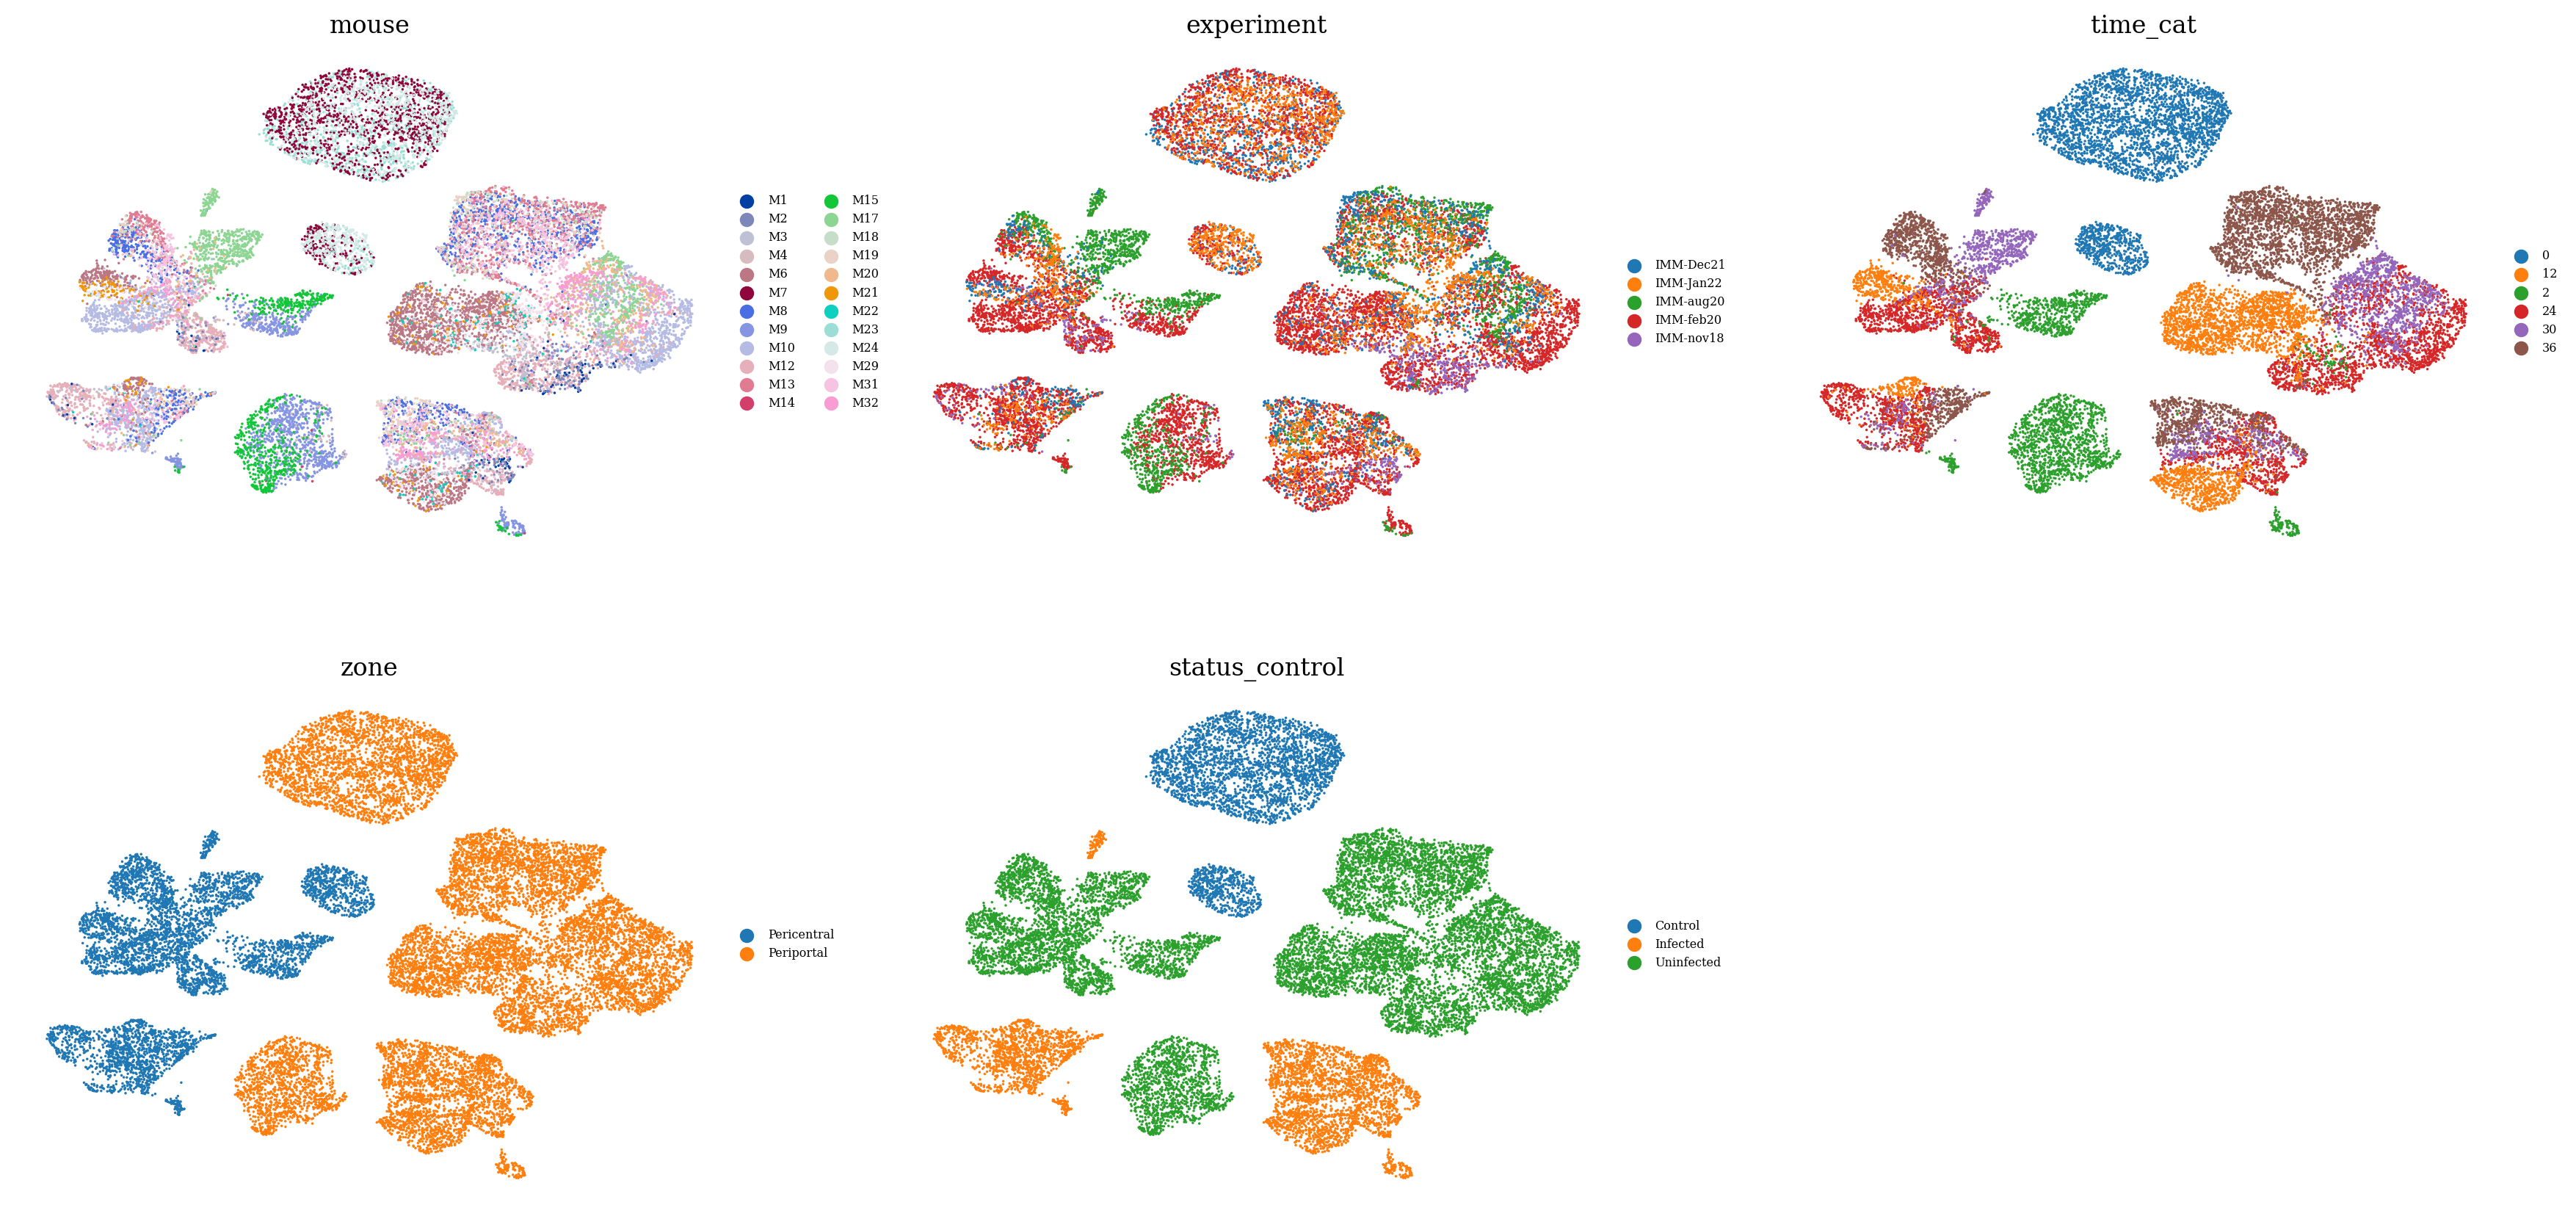

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

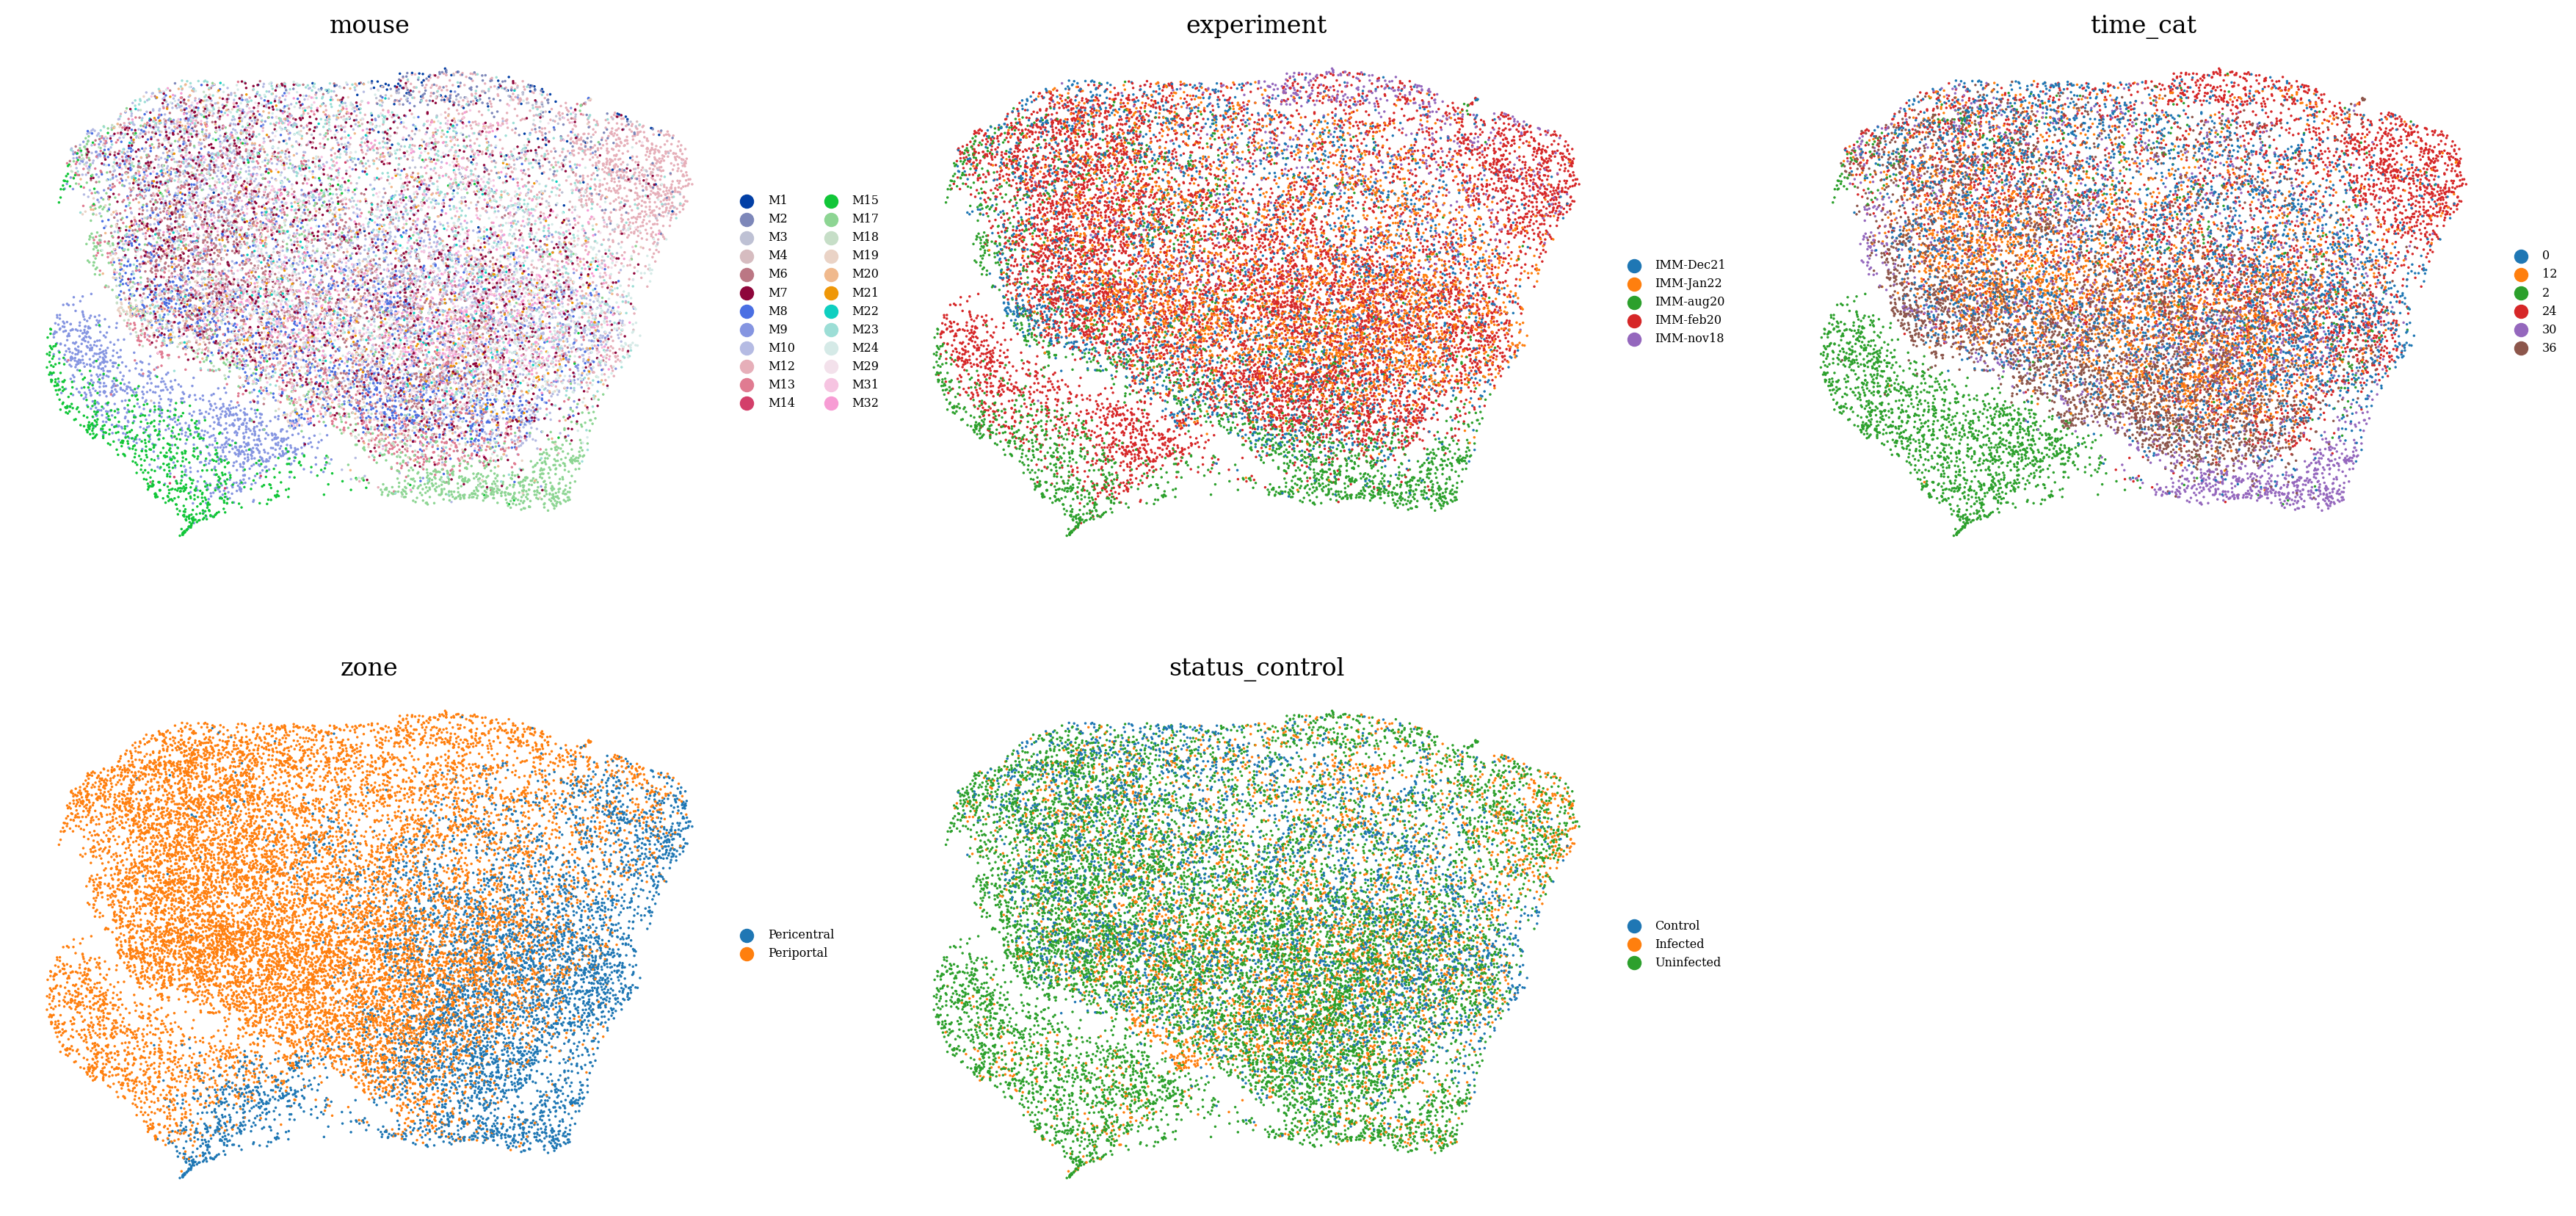

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  1%|          | 3/596 [00:00<00:20, 28.91it/s]

  5%|▍         | 29/596 [00:00<00:03, 160.49it/s]

  9%|▉         | 55/596 [00:00<00:02, 202.88it/s]

 14%|█▎        | 81/596 [00:00<00:02, 223.37it/s]

 18%|█▊        | 107/596 [00:00<00:02, 234.33it/s]

 22%|██▏       | 132/596 [00:00<00:01, 238.22it/s]

 26%|██▋       | 157/596 [00:00<00:01, 240.49it/s]

 31%|███       | 182/596 [00:00<00:01, 242.41it/s]

 35%|███▍      | 207/596 [00:00<00:01, 243.32it/s]

 39%|███▉      | 232/596 [00:01<00:01, 243.84it/s]

 43%|████▎     | 257/596 [00:01<00:01, 244.05it/s]

 47%|████▋     | 282/596 [00:01<00:01, 244.37it/s]

 52%|█████▏    | 307/596 [00:01<00:01, 244.32it/s]

 56%|█████▌    | 332/596 [00:01<00:01, 244.70it/s]

 60%|█████▉    | 357/596 [00:01<00:00, 244.64it/s]

 64%|██████▍   | 382/596 [00:01<00:00, 244.87it/s]

 68%|██████▊   | 407/596 [00:01<00:00, 244.70it/s]

 72%|███████▏  | 432/596 [00:01<00:00, 245.45it/s]

 77%|███████▋  | 457/596 [00:01<00:00, 245.39it/s]

 81%|████████  | 482/596 [00:02<00:00, 245.01it/s]

 85%|████████▌ | 507/596 [00:02<00:00, 244.53it/s]

 89%|████████▉ | 532/596 [00:02<00:00, 244.10it/s]

 93%|█████████▎| 557/596 [00:02<00:00, 245.10it/s]

 98%|█████████▊| 582/596 [00:02<00:00, 245.33it/s]

100%|██████████| 596/596 [00:02<00:00, 237.43it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

544

576

576

608

608

640

640

672

In [23]:
np.mean(r2s)

0.8976537577340018

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)